# LWFA1D: Optimal laser pulse duration

expected time of reading and running notebook: 30 minutes

&nbsp;


Notebook by: Óscar Amaro (2020)


References:

[1] B. Malaca , *Machine learning controlled plasma based acceleration*, MSc thesis, November 2018, chapter 3, https://fenix.tecnico.ulisboa.pt/cursos/meft/dissertacao/1972678479054386

[2] E. Esarey, C. B. Schroeder, and W. P. Leemans, *Lawrence Berkeley National Laboratory, Berkeley, California 94720, USA*, Rev. Mod. Phys. 81, 1229 – Published 27 August 2009, [DOI: 10.1103/RevModPhys.81.1229](https://doi.org/10.1103/RevModPhys.81.1229)


&nbsp;


Following reference [1] we show that there is an optimal laser pulse duration in LWFA 1D for flat laser profile. We use the code [ZPIC](https://github.com/zpic-plasma/zpic)

Begin by importing the necessary packages

In [1]:
# Add zpic library to path (assuming this notebook is in folder /classroom, for example)
import sys
sys.path.append("../../lib")

import em1d
import numpy as np
import matplotlib.pyplot as plt

We now define the simulation with a "square" pulse. The parameters `rise` and `fall` are given very low values, but the ensure smoothness they were kept finite. Also ZPIC does not accept null values for these variables.
The normalized field has the form (eq. 3.3 of [1])
$$a(x,t) = a_0 H(-(x-x_{xt})+ct) H((x-x_{end})-ct)$$

In [50]:
# laser
a0 = 0.05
wL = 10.0
start = 17
flat = 4.0

# Time step
dt = 0.019

# Simulation time
tmax = 25

# Number of cells
nx  = 1000

# Simulation box size
box = 20.0

dx = box/nx
rise = dx; fall = rise
xst = start-rise
xend = xst - flat - fall


## Background plasma

# Particles per cell
ppc = 128

# Use a step density profile
electrons = em1d.Species( "electrons", -1.0, ppc,
                           density = em1d.Density( type = "step", start = 20.0))

# Initialize simulation
sim = em1d.Simulation( nx, box, dt, species = electrons )

# Add laser pulse
sim.add_laser( em1d.Laser( start = start, rise=rise, fall=fall, flat=flat, a0 = a0, omega0 = wL, polarization = np.pi/2 ))

# Set moving window
sim.set_moving_window()

# Set current smoothing
sim.set_smooth( em1d.Smooth(xtype = "compensated", xlevel = 4) )

Check that the form of the initial focusing field is the correct one.

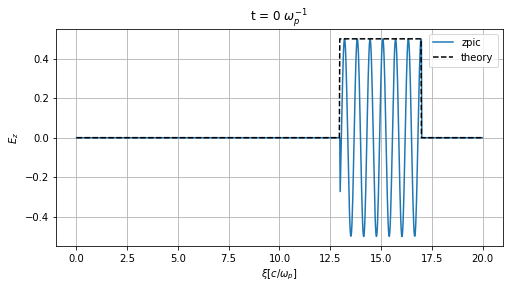

In [51]:
# Focusing field
fig = plt.figure(num=None, figsize=(8, 4))
xmin = sim.emf.dx/2
xmax = sim.emf.box - sim.emf.dx/2
xlst = np.linspace(xmin, xmax, num = sim.nx)
plt.plot(xlst, sim.emf.Ez,label='zpic')
plt.plot(xlst, a0*wL*np.heaviside(-(xlst-xst),0.5)*np.heaviside(xlst-xend,0.5),'--',color='black',label='theory')
plt.xlabel("$ξ[c/\omega_p]$")
plt.ylabel(r"$E_z$")
plt.title("t = {:g}".format(sim.t)+r"$\ \omega_p^{-1}$")
plt.grid(True)
plt.legend()
plt.show()

Recall that $ξ = x-ct$.

We now run the simulation

In [52]:
# Run the simulation
sim.run( tmax )


Running simulation up to t = 25 ...
n = 1316, t = 25.004
Done.


The accelerating field should have the form

$$ E_x(x) = E_0 f(x)$$
where $E_0 = a_0^2/2(1+a_0^2/2)^{-1/2}$ and

$$ f(x) =
\begin{cases}
    0, x > x_{st} + t\\
    -\sin(t-(x-x_{st}))/2, x_{end}+t <x < x_{st}+t\\
    -\sin(t-(x-x_{st}))/2+\sin(t-(x-x_{end}))/2, x < x_{end}+t
\end{cases} $$

(eq 3.4 of [1])

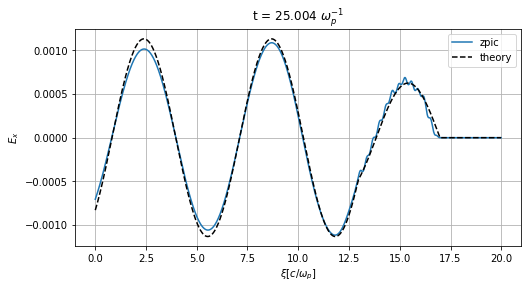

In [53]:
# Accelerating field
def Extheory(x):
    res = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]>xst:
            res[i] = 0
        elif xend <= x[i] <= xst:
            res[i] = np.sin(-(x[i]-xst))/2
        else:
            res[i] = (np.sin(-(x[i]-xst)) - np.sin(-(x[i]-xend)))/2
    return res
fig = plt.figure(num=None, figsize=(8, 4))
xmin = sim.emf.dx/2
xmax = sim.emf.box - sim.emf.dx/2
xlst = np.linspace(xmin, xmax, num = sim.nx)
xlst2 = np.linspace(xmin, xmax, 2000)
plt.plot(xlst, sim.emf.Ex,label='zpic')
plt.plot(xlst2, Extheory(xlst2)*(a0**2/2)/np.sqrt(1+a0**2/2),'--',color='black',label='theory')
plt.xlabel("$ξ[c/\omega_p]$")
plt.ylabel(r"$E_x$")
plt.title("t = {:g}".format(sim.t)+r'$\ \omega_p^{-1}$')
plt.grid(True)
plt.legend()
plt.show()

The theory seems to predict the accelerating field quite well.

We now search for the maximum

In [29]:
flatdim = 11
flatlst = np.linspace(np.pi/10,5,flatdim)
maxEx = np.zeros(flatdim)

for i in range(flatdim):
    #print(i)
    start = 27
    flat = flatlst[i]
    rise = .01; fall = .01
    a0 = 0.05
    # Number of cells
    nx  = 1500
    # Simulation box size
    box = 30.0
    # Time step
    dt = 0.99*box/nx
    # Simulation time
    tmax = 35
    ## Background plasma
    # Particles per cell
    ppc = 32
    # Use a step density profile
    electrons = em1d.Species( "electrons", -1.0, ppc,
                               density = em1d.Density( type = "step", start = 30.0))
    # Initialize simulation
    sim = em1d.Simulation( nx, box, dt, species = electrons )
    # Add laser pulse
    sim.add_laser( em1d.Laser( start = start, rise=.01, fall=.01, flat=flat, a0 = a0, omega0 = wL, polarization = np.pi/2 ))
    # Set moving window
    sim.set_moving_window()
    # Set current smoothing
    sim.set_smooth( em1d.Smooth(xtype = "compensated", xlevel = 4) )
    # Run the simulation
    sim.run( tmax )

    # save maximum value
    maxEx[i] = max(sim.emf.Ex)


Running simulation up to t = 35 ...
n = 1768, t = 35.0064
Done.

Running simulation up to t = 35 ...
n = 1768, t = 35.0064
Done.

Running simulation up to t = 35 ...
n = 1768, t = 35.0064
Done.

Running simulation up to t = 35 ...
n = 1768, t = 35.0064
Done.

Running simulation up to t = 35 ...
n = 1768, t = 35.0064
Done.

Running simulation up to t = 35 ...
n = 1768, t = 35.0064
Done.

Running simulation up to t = 35 ...
n = 1768, t = 35.0064
Done.

Running simulation up to t = 35 ...
n = 1768, t = 35.0064
Done.

Running simulation up to t = 35 ...
n = 1768, t = 35.0064
Done.

Running simulation up to t = 35 ...
n = 1768, t = 35.0064
Done.

Running simulation up to t = 35 ...
n = 1768, t = 35.0064
Done.


We now see the results

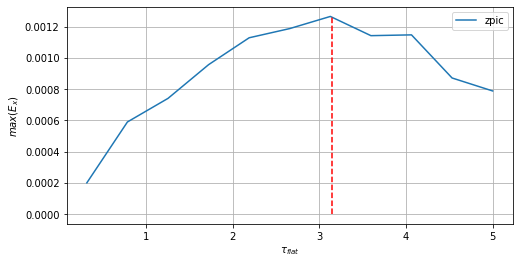

In [31]:
# Focusing field
fig = plt.figure(num=None, figsize=(8, 4))
xmin = sim.emf.dx/2
xmax = sim.emf.box - sim.emf.dx/2
plt.plot(flatlst,maxEx.flatten(),label='zpic')
plt.plot([np.pi,np.pi],[0,max(maxEx)],'--r') # vertical line through theoretical maximum
plt.xlabel(r'$\tau_{flat}$')
plt.ylabel(r"$max(E_x)$")
plt.grid(True)
plt.legend()
plt.show()

As expected, the optimal value for the flat component is around $\pi$ (in these units).